# Modello convolutivo di base - Dataset rumore
In precedenza abbiamo visto l'addestramento del nostro modello convolutivo di base sul dataset originale, e dopodiché abbiamo parlato della data augmentation.

AGGIORNARE

Come al solito, implementiamo le librerie funzioni necessarie. Inoltre otteniamo il nuovo dataset attraverso le tecniche viste nel notebook relativo alla data augmentation.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import random
import os
import time
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

## Classe per la conversione del dataset
Questa classe l'abbiamo già vista implementata nel notebook riguardante l'addestramento dei filterbanks e degli mfcc.

In [2]:
class DatasetConverter:
    def __init__(self, dataset):
        self.dataset = dataset

    def convert(self, option):
        available_options = ['spettrogrammi', 'filterbanks', 'mfcc']
        
        if option == available_options[0]:
            return self.get_spectrogram_dataset()
        elif option == available_options[1]:
            return self.get_filterbanks_dataset()
        elif option == available_options[2]:
            return self.get_mfcc_dataset()
        else:
            raise ValueError(f"Opzione non disponibile: inserire una delle seguenti opzioni: {available_options}")
    
    # INIZIO SPETTROGRAMMI
    def squeeze(self, audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    def get_spectrogram(self, waveform):
    # applichiamo la short-time Fourier transorm
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        spectrogram = tf.abs(spectrogram)
        
        return spectrogram[..., tf.newaxis]
    
    def get_spectrogram_dataset(self):
        # squeeze
        self.dataset = self.dataset.map(self.squeeze, tf.data.AUTOTUNE)
        self.dataset = self.dataset.map(lambda x, y: (self.get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
        return self.dataset

    # FINE SPETTROGRAMMI

    def convert_to_numpy(self, dataset):
        audio_data = []
        labels = []
    
        dataset = dataset.unbatch()
        
        for audio, label in dataset:
            audio_data.append(audio.numpy())  # Assuming audio is a tensor, convert to numpy array
            labels.append(label.numpy())      # Assuming label is a tensor, convert to numpy array
        
        audio_data = np.array(audio_data)
        labels = np.array(labels)
        
        return audio_data, labels
    
    # INIZIO FILTERBANKS
    def makeHamming(self, M):
        R = (( M - 1 ) / 2 , M / 2)[M % 2 == 0]
        w = (np.hamming(M), np.hamming(M + 1))[M % 2 == 0]
        if M % 2 != 0:
            w[0] = w[0]/2
            w[M-1] = w[M-1]/2
        else:
            w = w[:M]
    
        return w

    def hztomel(self, hz):
        return (2595 * np.log10(1 + hz / 700))

    def meltohz(self, mel):
        return (700 * (10**(mel / 2595) - 1))

    def compute_filterbanks(self, audios_np, pre_emphasis=0.97, sample_rate=16000, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=40):
        filterbanks_np = []
        
        for samples in audios_np:
            emphasized_audio = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
            audio_length = len(emphasized_audio)
    
            frame_length, frame_step = int(frame_size * sample_rate), int(frame_stride * sample_rate)
    
            num_frames = int(np.ceil(float(np.abs(audio_length - frame_length)) / frame_step))
    
            pad_audio_length = num_frames * frame_step + frame_length
            z = np.zeros((pad_audio_length - audio_length))
            pad_audio = np.append(emphasized_audio, z)
    
            indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
            frames = pad_audio[indices.astype(np.int32, copy=False)]
    
            # Usiamo la funzione di Hamming
            hamming_window = self.makeHamming(frame_length)
    
            mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitudo della FFT
            pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
            # convertiamo hz in mel
            low_freq_mel = self.hztomel(0)
            high_freq_mel = self.hztomel(sample_rate / 2)
    
            mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
            hz_points = self.meltohz(mel_points) 
    
            bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
            fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    
            for m in range(1, nfilt + 1):
                f_m_minus = int(bin[m - 1])
                f_m = int(bin[m])
                f_m_plus = int(bin[m + 1])
    
                for k in range(f_m_minus, f_m):
                    fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
                for k in range(f_m, f_m_plus):
                    fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
            # in questo momento invece calcoliamo i filter banks per i segmenti di audio, utilizzando i filtri triangolari appena creati
            filter_banks = np.dot(pow_frames, fbank.T)
            filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
            filter_banks = 20 * np.log10(filter_banks)
    
            filterbanks_np.append(filter_banks)
        
        return np.array(filterbanks_np)
    
    def get_filterbanks_dataset(self): 
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        filterbanks = np.expand_dims(filterbanks, axis=-1)

        self.dataset = tf.data.Dataset.from_tensor_slices((filterbanks, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    # FINE FILTERBANKS

    # INIZIO MFCC
    def compute_mfcc(self, filter_banks, num_ceps=12, cep_lifter=22):
        mfcc_np = []
        
        for f in filter_banks:
            mfcc = scipy.dct(f, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)
            
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift

            mfcc_np.append(mfcc)
        
        return np.array(mfcc_np)
    
    
    def get_mfcc_dataset(self):
        audios, labels = self.convert_to_numpy(self.dataset)

        filterbanks = self.compute_filterbanks(audios)
        mfcc = self.compute_mfcc(filterbanks)
        
        mfcc = np.expand_dims(mfcc, axis=-1)
        
        self.dataset = tf.data.Dataset.from_tensor_slices((mfcc, labels))
        self.dataset = self.dataset.batch(32)
        
        return self.dataset
    
    # FINE MFCC

## Importazione funzioni ulteriori
In aggiunta alla classe per la conversione del dataset, ci serviremo delle seguenti funzioni: 
- `convert_history_to_csv` - salva l'history dell'addestramento in un csv
- `convert_model_to_onnx` - converte il miglior modello **.keras** in **.onnx**
- `create_train_val_plot` - visualizza l'andamento dell'accuratezza e della perdita durante l'addestramento
- `evaluate_onnx_model` - valuta il modello sui dati di test con il modello **.onnx**
- `create_distribution_plot` - visualizza la distribuzione di accuratezza delle classi su un'immagine casuale

Anch'esse sono già state viste, perciò non ci soffermeremo troppo su di esse.

In [21]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)
    
    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()
    
    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)
    
    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds], dtype=np.float32)
    labels_np = np.array([label.numpy() for _, label in test_ds])
    
    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

def create_distribution_plot(model, audio, label):
    label_names = audio_label_names
    
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe no, magari così cambia un po' le classi che mostriamo

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))
    
    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo la legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

In [4]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory ='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split 
)
audio_label_names = train_ds.class_names

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

noise_label_names = noise_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 14 files belonging to 14 classes.


## Applicazione tecniche data augmentation
Abbiamo già visto l'utilizzo delle tecniche che andremo a applicare in questo momento, perciò non ci soffermeremo sulla loro spiegazione ma descriveremo i passaggi molto sinteticamnete.

Tagliamo gli audio del dataset rumoroso.

In [5]:
def cut_audios(dataset, length):
    new_audios = [] # inizializziamo una lista dove inseriremo i nostri audio tagliati
    labels = []
    
    # iteriamo nel dataset
    for audio, label in dataset:
        # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
        labels.append(label.numpy())
        
        audio = tf.reshape(audio, [-1])[np.shape(audio)[1]//2:np.shape(audio)[1]//2 + length]
        new_audios.append(audio.numpy()) # convertiamo in array per poterli modificare
        
    return new_audios, labels

cut_noise_audios, cut_noise_labels = cut_audios(noise_ds, 16000)

Creiamo il nuovo dataset, unendo l'originale con quello rumoroso. L'output che otteneremo è una lista.

In [6]:
def mix_audios(original_audios, noise_audios):
    mixed_dataset = [] # inizializziamo la lista dove inseriremo gli audio uniti al rumore

    original_audios = original_audios.unbatch() # il nostro training set ha una batch_size di 32, per rendere il processo più semplice unbatchiamo
    
    # per ogni audio del dataset originale
    for audio, label in original_audios:    
        audio = np.squeeze(audio, axis=-1) # rimuoviamo l'ultima asse inutile (quella dei canali)
        
        # Scegliamo in modo randomico un audio dalla lista degli audio rumorosi
        noise_sample = random.choice(noise_audios)

        # calcolo l'ampiezza massima dell'audio rumoroso
        max_amplitude_audio = np.max(np.abs(audio))
        max_amplitude_noise = np.max(np.abs(noise_sample))
        # calcolo un noise factor che varia a seconda dell'ampiezza massima di entrambi gli audio
        noise_factor = max_amplitude_audio / max_amplitude_noise
        noise_factor = min(noise_factor, 1.0)
        
        noise_sample = noise_sample * noise_factor
        
        mixed_audio = audio + noise_sample # uniamo l'audio original al rumore

        # aggiungiamo l'audio con noise alla lista
        mixed_dataset.append((mixed_audio, label))

    return mixed_dataset

mixed_train_list = mix_audios(train_ds, cut_noise_audios)
mixed_val_list = mix_audios(validation_ds, cut_noise_audios)

Convertiamo la lista in un dataset di tensori.

In [7]:
def create_mixed_ds(dataset_list):
    audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in dataset_list]
    labels = [label for _, label in dataset_list]

    audio_data = tf.expand_dims(audio_data, axis=-1)
    
    mixed_train_ds = tf.data.Dataset.from_tensor_slices((audio_data, labels))
    mixed_train_ds = mixed_train_ds.batch(32)
    return mixed_train_ds

mixed_train_ds = create_mixed_ds(mixed_train_list)
mixed_validation_ds = create_mixed_ds(mixed_val_list)

## Suddivisione dataset
Ottenuto il dataset rumoroso possiamo procedere a convertirlo e suddividerlo.

In [8]:
mixed_train_ds = DatasetConverter(mixed_train_ds)
mixed_train_ds = mixed_train_ds.convert("spettrogrammi")

mixed_validation_ds = DatasetConverter(mixed_validation_ds)
mixed_validation_ds = mixed_validation_ds.convert("spettrogrammi")

mixed_val_ds = mixed_validation_ds.take(mixed_validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
mixed_test_ds = mixed_validation_ds.skip(mixed_validation_ds.cardinality() // 2)

Adesso siamo pronti per addestrare i modelli su un dataset rumoroso.

## Addestramento
Come già detto, le reti neurali convolutive che andremo a trattare sono le stesse presenti nel notebook del modello convolutivo base. Stiamo addestrando gli stessi modelli in modo da poter confrontare le loro prestazioni in un notebook a parte.

Iniziamo con il primo modello base.

In [9]:
def get_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1), name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
basic_model = get_basic_model()
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/rmsprop/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(mixed_train_ds, epochs=30, validation_data=mixed_val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 6s 12ms/step - loss: 2.9934 - accuracy: 0.1598 - val_loss: 2.6077 - val_accuracy: 0.2755
Epoch 2/30
243/243 [==============================] - 3s 10ms/step - loss: 1.9266 - accuracy: 0.4508 - val_loss: 1.6388 - val_accuracy: 0.5243
Epoch 3/30
243/243 [==============================] - 3s 10ms/step - loss: 1.1676 - accuracy: 0.6559 - val_loss: 1.3985 - val_accuracy: 0.5976
Epoch 4/30
243/243 [==============================] - 3s 11ms/step - loss: 0.7750 - accuracy: 0.7684 - val_loss: 1.2674 - val_accuracy: 0.6389
Epoch 5/30
243/243 [==============================] - 3s 10ms/step - loss: 0.5540 - accuracy: 0.8378 - val_loss: 1.3004 - val_accuracy: 0.6929
Epoch 6/30
243/243 [==============================] - 3s 11ms/step - loss: 0.3902 - accuracy: 0.8799 - val_loss: 1.6953 - val_accuracy: 0.6701
Epoch 7/30
243/243 [==============================] - 3s 11ms/step - loss: 0.2980 - accuracy: 0.9115 - val_loss: 1.6892 - val_accuracy: 0.7438

Salviamo i dati della history del modello in un file csv

In [11]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/noise/rmsprop/basic_model_history.csv")

Salviamo il miglior modello come file csv nella seguente directory `model_histories/noise/rmsprop/` con il nome `basic_model_history`. Inoltre, per prevenire errori di salvataggio causati da versioni differenti di python o dei pacchetti, procediamo con la conversione del file in formato standard `.onnx`.

In [12]:
convert_model_to_onnx("bestmodels/noise/rmsprop/basic_model.keras", (124, 129, 1))

Utilizziamo la funzione `create_train_val_plot` per mostrare l'andamento dell'accurateza e della perdita durante l'addestramento.

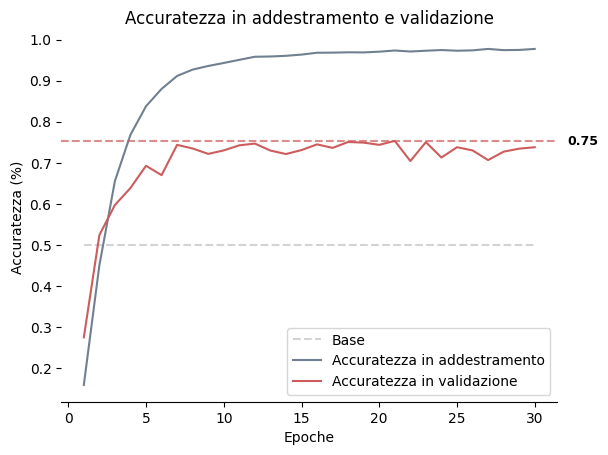

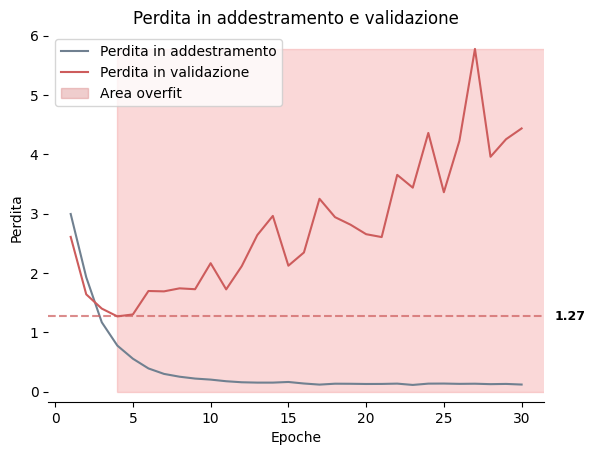

In [13]:
create_train_val_plot(basic_model_history.history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione si attesta sull'**75%**. La **perdita nel set di addestramento** continua a diminuire dopo la **quinta epoca**, mentre la **perdita nel set di validazione** aumenta.

Non siamo riusciti a raggiungere una buona accuratezza nella validazione.
### CAPIAMO IL PERCHE'

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**

In [17]:
best_basic_model = tf.keras.models.load_model("bestmodels/noise/rmsprop/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 5ms/step - loss: 1.3221 - accuracy: 0.6366
Accuratezza: 0.637


In [15]:
evaluate_onnx_model("bestmodels/noise/rmsprop/basic_model.onnx", mixed_test_ds)

Accuratezza: 0.637


Abbiamo ottenuto un'**accuratezza** del **63.7%**, possiamo già notare un peggioramento notevole. Visualizziamo la distribuzione di accuratezza delle classi su un'immagine casuale.

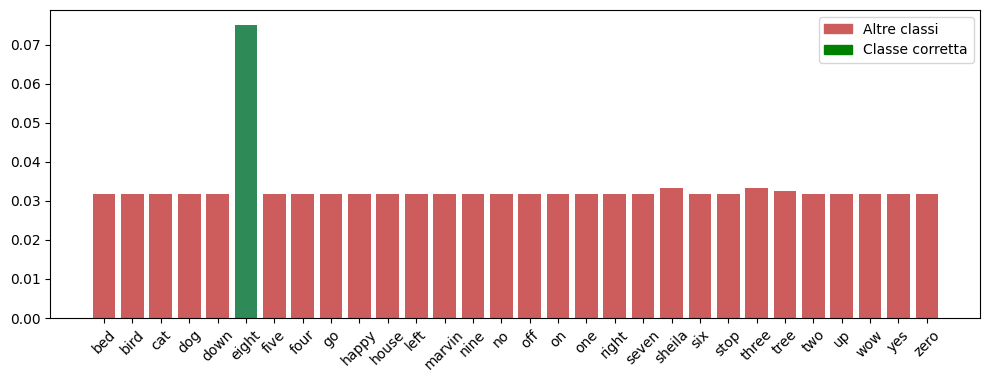

In [22]:
for audio, label in mixed_test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

### Risoluzione dell'overfitting
Il modello è andato immediatamente in **overfitting**, e lo possiamo notare dalla loss di validazione che inizia a salire dalla quinta epoca in poi. Cercheremo di ritardarla leggermente seguendo le stesse procedure del notebook di riferimento.

In [23]:
def get_improved_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [24]:
improved_basic_model = get_improved_basic_model()
improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [26]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/rmsprop/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(mixed_train_ds, epochs=100, validation_data=mixed_val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 3s 11ms/step - loss: 3.0145 - accuracy: 0.1518 - val_loss: 2.6400 - val_accuracy: 0.2751
Epoch 2/100
243/243 [==============================] - 3s 11ms/step - loss: 2.0271 - accuracy: 0.4116 - val_loss: 1.7132 - val_accuracy: 0.5100
Epoch 3/100
243/243 [==============================] - 3s 10ms/step - loss: 1.3735 - accuracy: 0.6021 - val_loss: 1.4666 - val_accuracy: 0.6034
Epoch 4/100
243/243 [==============================] - 3s 10ms/step - loss: 1.0042 - accuracy: 0.7004 - val_loss: 1.2374 - val_accuracy: 0.6775
Epoch 5/100
243/243 [==============================] - 3s 10ms/step - loss: 0.7602 - accuracy: 0.7758 - val_loss: 1.1048 - val_accuracy: 0.7022
Epoch 6/100
243/243 [==============================] - 2s 10ms/step - loss: 0.6111 - accuracy: 0.8137 - val_loss: 1.1703 - val_accuracy: 0.6863
Epoch 7/100
243/243 [==============================] - 3s 10ms/step - loss: 0.5022 - accuracy: 0.8479 - val_loss: 1.2141 - val_accuracy:

Salviamo come prima la history del modello in un file csv, e convertiamo il miglior modello nel formato **.onnx**.

In [27]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/noise/rmsprop/improved_history.csv")

convert_model_to_onnx("bestmodels/noise/rmsprop/improved_basic_model.keras", (124, 129, 1))

Visualizziamo la curva dell'accuratezza e della perdita durante l'addestramento.

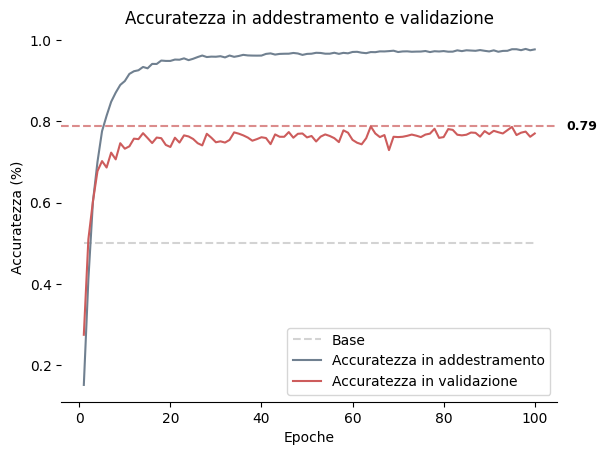

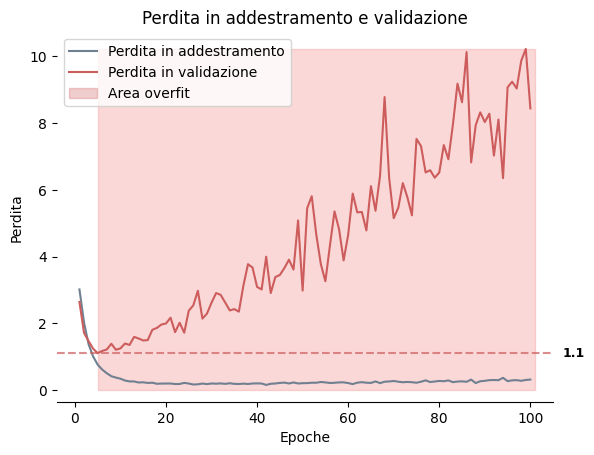

In [28]:
create_train_val_plot(improved_history.history)

Le prestazioni sono leggermente migliorate rispetto all'applicazione precedente. Verifichiamo l'accuratezza nel dataset di test.

In [30]:
improved_best_model = tf.keras.models.load_model("bestmodels/noise/rmsprop/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 6ms/step - loss: 1.1378 - accuracy: 0.7148
Accuratezza: 0.715


In [31]:
evaluate_onnx_model("bestmodels/noise/rmsprop/improved_basic_model.onnx", mixed_test_ds)

Accuratezza: 0.715


Abbiamo ottenuto un notevole miglioramento dell'accuratezza, attualmente siamo a quota **71.5%**! Visualizziamo anche la solita distribuzione.

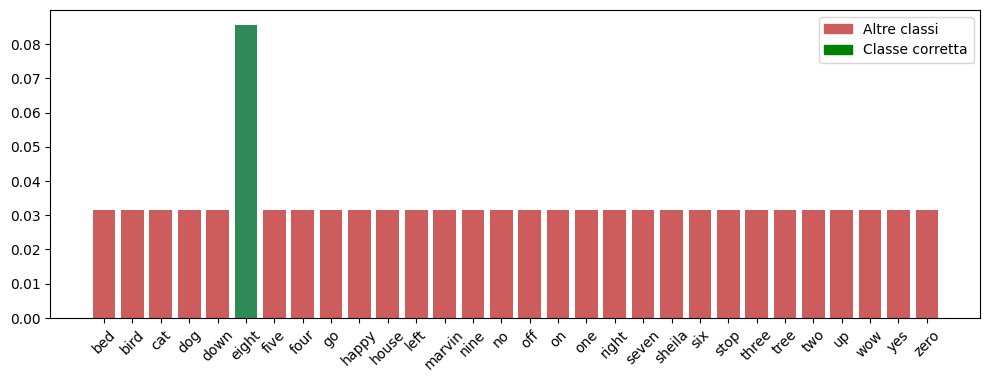

In [32]:
for audio, label in mixed_test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

### Fine tuning
In questa sezione andremo a effettuare il fine tuning del modello convolutivo con la stessa metodologia del notebook di riferimento.

In [35]:
def get_improved_basic_model_tuning(start_filters):
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Normalization()(inputs)

    if not isinstance(start_filters, int):
        raise Exception("start_filters must be type integer")

    filters = [start_filters * (2 ** i) for i in range(4)]
    
    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def tuner(filters, learning_rates, max_epochs, train_dataset, validation_dataset):
    start_time = time.time()

    counter = 1
    
    if not isinstance(filters, list):
        raise Exception("parameter filters must be type list")

    if not isinstance(learning_rates, list):
        raise Exception("parameter learning_rates must be type list")

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

    best_learning_rate = 0 
    best_filters = 0
    best_val_accuracy = 0

    best_model = 0
    
    for f in filters:
        for lr in learning_rates:
            print(f"\nAddestrando con filtri {[f * (2 ** i) for i in range(4)]} e tasso di apprendimento {lr}")
            
            model = get_improved_basic_model_tuning(start_filters=f)
            model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=["accuracy"])
            model_history = model.fit(train_dataset, epochs=max_epochs, validation_data=validation_dataset, callbacks=callbacks)

            model_history_df = convert_history_to_csv(model_history)

            model_history_df[["filters"]] = f
            model_history_df[["learning_rate"]] = lr
            
            path = "model_tuning/histories/rmsprop/model_" + str(counter) + ".csv"
            model_history_df.to_csv(path)
            
            if best_val_accuracy < model_history_df.iloc[-1]["val_accuracy"]:
                best_val_accuracy = model_history_df.iloc[-1]["val_accuracy"]
                best_filters = f
                best_learning_rate = lr
                epoch = len(model_history_df)

            del model

            counter += 1

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"\nTempo totale trascorso: {int(minutes)} minuti e {int(seconds)} secondi")
    # print(f"Il miglior modello ha un filtro di partenza pari a {best_filters}, un learning rate pari a {best_learning_rate} con un'accuracy pari a {best_val_accuracy:.3f}")

    return best_filters, best_learning_rate

best_filter, best_learning_rate = tuner([16, 32, 64], [1e-3, 1e-4, 1e-5], 30, mixed_train_ds, mixed_val_ds)


Addestrando con filtri [16, 32, 64, 128] e tasso di apprendimento 0.001
Epoch 1/30
243/243 [==============================] - 3s 7ms/step - loss: 3.0345 - accuracy: 0.1457 - val_loss: 2.9513 - val_accuracy: 0.2226
Epoch 2/30
243/243 [==============================] - 2s 7ms/step - loss: 2.2553 - accuracy: 0.3540 - val_loss: 2.0606 - val_accuracy: 0.4062
Epoch 3/30
243/243 [==============================] - 2s 7ms/step - loss: 1.6300 - accuracy: 0.5236 - val_loss: 1.6014 - val_accuracy: 0.5455
Epoch 4/30
243/243 [==============================] - 2s 7ms/step - loss: 1.2438 - accuracy: 0.6383 - val_loss: 1.2817 - val_accuracy: 0.6323
Epoch 5/30
243/243 [==============================] - 2s 6ms/step - loss: 1.0004 - accuracy: 0.7034 - val_loss: 1.2130 - val_accuracy: 0.6443
Epoch 6/30
243/243 [==============================] - 2s 6ms/step - loss: 0.8236 - accuracy: 0.7564 - val_loss: 1.0445 - val_accuracy: 0.6991
Epoch 7/30
243/243 [==============================] - 2s 6ms/step - loss: 0

Il tempo necessario per la ricerca dei migliori iperparametri è stata di quasi **10 minuti**.

Definiamo e utilizziamo la funzione `plot_models` per visualizzare l'accuratezza e la perdita di tutti i modelli che il tuner ha addestrato.

In [36]:
def plot_models(path, reverse=False, show="accuracy", overfit=True):
    n_models = len(os.listdir(path))
    # creo il subplot a seconda di quanti modelli dispongo
    best_pair = None
    min_diff = float("inf")
    
    for idx_model in range(1, int(np.sqrt(n_models)) + 1):
        if n_models % idx_model == 0:
            diff = abs(idx_model - n_models // idx_model)

            if diff < min_diff:
                min_diff = diff
                best_pair = (idx_model, n_models // idx_model)

    if reverse:
        rows = best_pair[1]
        cols = best_pair[0]
    else:
        rows = best_pair[0]
        cols = best_pair[1]
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
    
    for index, model in enumerate(os.listdir(path)):
        row = index // cols
        col = index % cols
    
        ax = axes[row][col]
        
        newpath = path + "/" + model
        df = pd.read_csv(newpath)

        value1 = df[show].values
        value2 = df["val_" + show].values
        
        ax.plot(range(1, len(value1) + 1), value1, color="slategray", label="Addestramento")
        ax.plot(range(1, len(value2) + 1), value2, color="indianred", label="Validazione")

        if (row in range(rows)) and col == 0:
            ax.set_ylabel("Accuratezza (%)" if show == "accuracy" else "Perdita", fontweight="semibold", fontsize=10)

        if (col in range(cols)) and row == 2:
            ax.set_xlabel("Epoche", fontweight="semibold", fontsize=10)

        ax.set_title("Filtro " + str(df["filters"][0]) + " & lr " + str(df["learning_rate"][0]), fontsize=12)
            
        ax.set_ylim(0)
        ax.set_xlim(0)

        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.grid(True, color="gainsboro", alpha=0.3, linestyle="--")

        handles, _ = ax.get_legend_handles_labels()
        
        if overfit and show == "loss":
            # area overfit
            
            rect = mpatches.Rectangle((np.argmin(value2) + 1, 0), width=len(value1) - np.argmin(value2), height=max(max(value1), max(value2)), color='lightcoral', alpha=0.3)
            ax.add_patch(rect)
            # patch overfit per legenda
            overfit = mpatches.Patch(color='lightcoral', alpha=0.3, label='Area overfit')
           
            handles.append(overfit)

        ax.legend(handles=handles)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

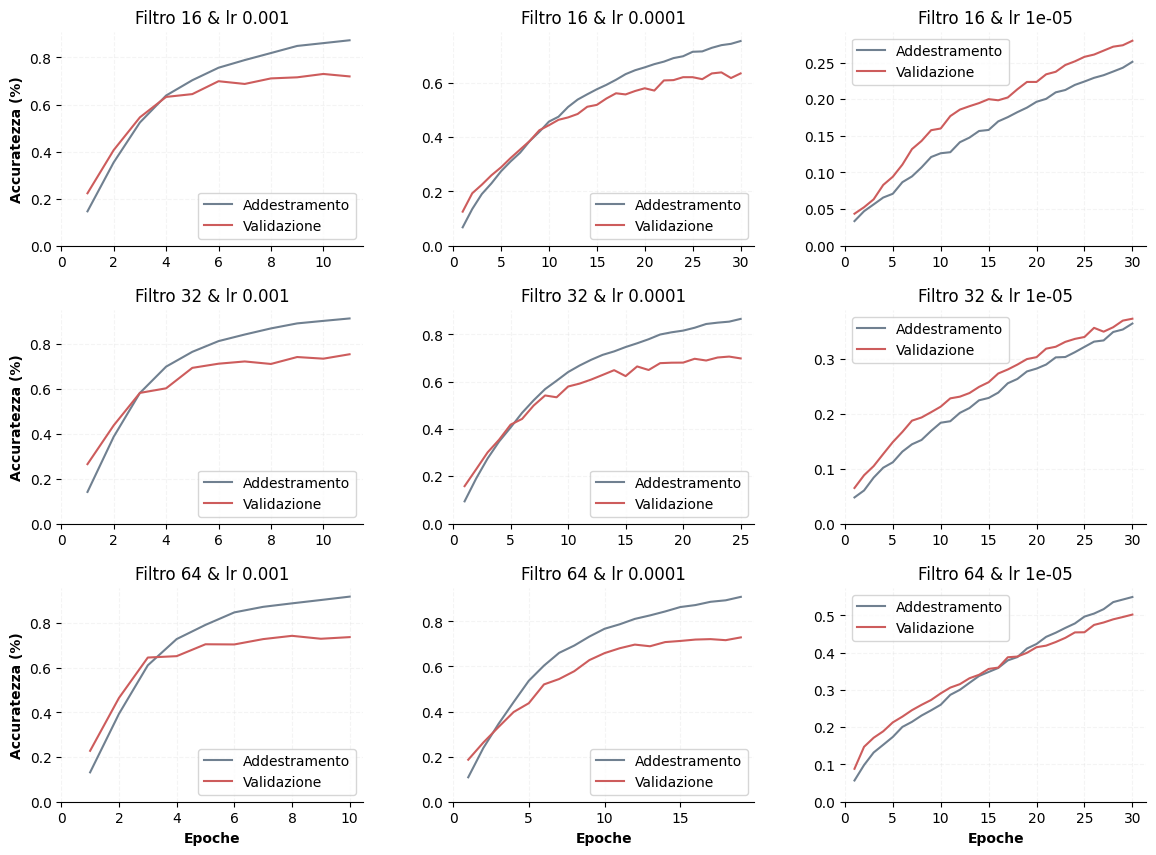

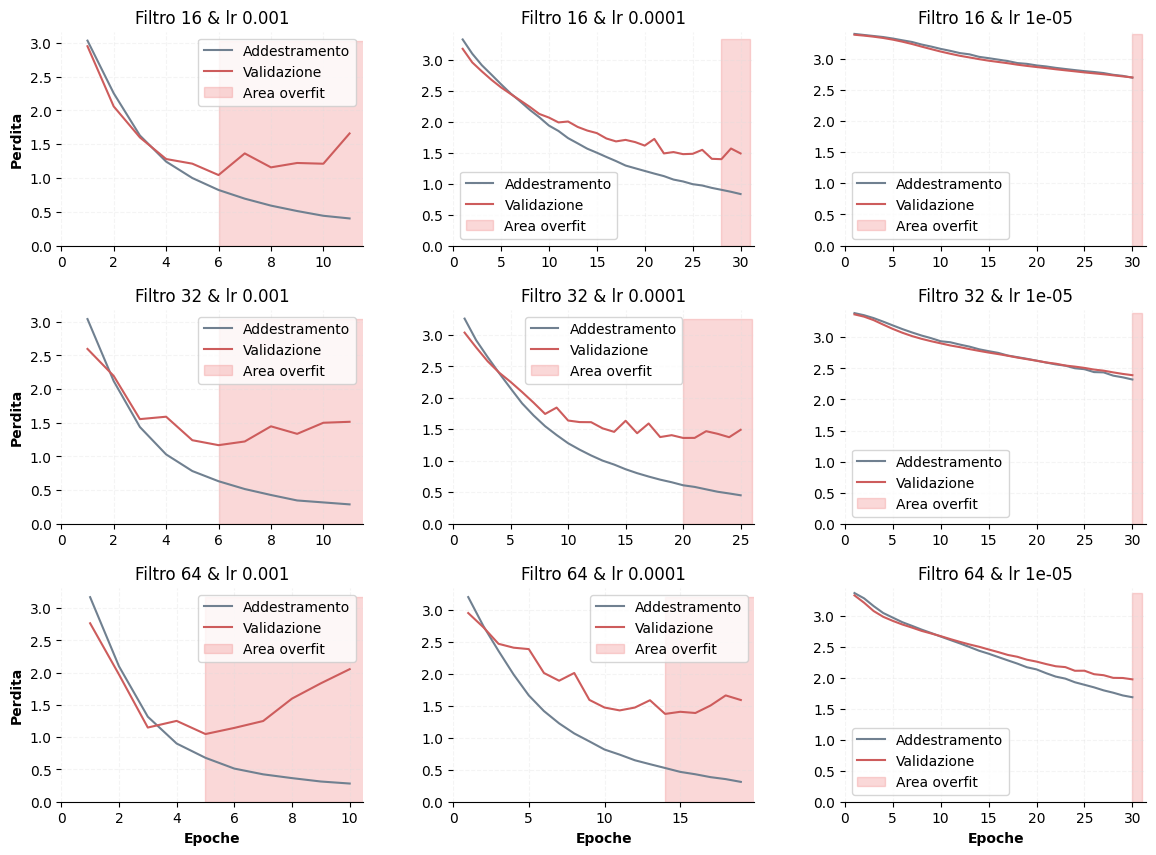

In [37]:
plot_models(path="model_tuning/histories/rmsprop", show="accuracy")
plot_models(path="model_tuning/histories/rmsprop", show="loss")

Dai grafici emerge che la combinazione più performante è composta da **XX filtri di partenza** e un **tasso di apprendimento di XX**, poiché ritarda maggiormente l'overfitting. Altre combinazioni, come **XX filtri di partenza** e un **tasso di apprendimento di 1e-5**, mostrano buone prestazioni ma anche un inizio di overfitting, evidenziato dallo distaccamento tra la perdita di addestramento e quella di validazione.

Procediamo quindi con l'addestramento del modello con **XX filtri di partenza** e un **tasso di apprendimento di XX**. Come di consueto, salviamo i risultati in un file `keras` e la cronologia (history) in un file `csv`. Infine, convertiamo il file in formato `onnx`.

In [ ]:
tuned_improved_basic_model = get_improved_basic_model()
tuned_improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=AGGIUNGERE), metrics=["accuracy"])

In [ ]:
tuned_improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/rmsprop/tuned_improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
tuned_improved_history = tuned_improved_basic_model.fit(mixed_train_ds, epochs=100, validation_data=mixed_val_ds, callbacks=tuned_improved_basic_model_callbacks)

In [ ]:
tuned_improved_history_df = convert_history_to_csv(tuned_improved_history)
tuned_improved_history_df.to_csv("model_histories/noise/rmsprop/tuned_improved_history.csv")

convert_model_to_onnx("bestmodels/noise/rmsprop/tuned_improved_basic_model.keras", (124, 129, 1))

In [ ]:
create_train_val_plot(tuned_improved_history.history)

In [ ]:
tuned_improved_best_model = tf.keras.models.load_model("bestmodels/noise/rmsprop/tuned_improved_basic_model.keras")
test_loss, test_acc = tuned_improved_best_model.evaluate(mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

In [ ]:
evaluate_onnx_model("bestmodels/noise/rmsprop/tuned_improved_basic_model.onnx", mixed_test_ds)

AGGIUNGERE COMMENTO SU COME SI E' AGGIORNATO. L'accuratezza è attualmente **XX%**.

In [ ]:
for audio, label in mixed_test_ds:
    create_distribution_plot(tuned_improved_best_model, audio, label)
    break

### Miglioramenti all'architettura del modello
Procediamo quindi con la fase corrispettiva al notebook di riferimento.

In [38]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

In [39]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    
    x = residual_block(inputs, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [40]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [41]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/noise/rmsprop/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(mixed_train_ds, epochs=100, validation_data=mixed_val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 6s 21ms/step - loss: 3.4645 - accuracy: 0.0661 - val_loss: 3.3795 - val_accuracy: 0.0475
Epoch 2/100
243/243 [==============================] - 5s 20ms/step - loss: 3.0574 - accuracy: 0.1340 - val_loss: 3.0665 - val_accuracy: 0.1412
Epoch 3/100
243/243 [==============================] - 5s 20ms/step - loss: 2.7741 - accuracy: 0.2068 - val_loss: 3.2277 - val_accuracy: 0.1381
Epoch 4/100
243/243 [==============================] - 5s 21ms/step - loss: 2.4771 - accuracy: 0.2906 - val_loss: 2.9723 - val_accuracy: 0.1971
Epoch 5/100
243/243 [==============================] - 5s 20ms/step - loss: 2.2137 - accuracy: 0.3695 - val_loss: 3.1482 - val_accuracy: 0.2188
Epoch 6/100
243/243 [==============================] - 5s 20ms/step - loss: 2.0014 - accuracy: 0.4241 - val_loss: 3.0780 - val_accuracy: 0.2346
Epoch 7/100
243/243 [==============================] - 5s 20ms/step - loss: 1.8259 - accuracy: 0.4781 - val_loss: 2.8435 - val_accuracy:

Salviamo nuovamente la history del modello in un file csv e convertiamo il miglior modello nel formato **.onnx**.

In [42]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/noise/rmsprop/bp_model_history.csv")

convert_model_to_onnx("bestmodels/noise/rmsprop/bp_basic_model.keras", (124, 129, 1))

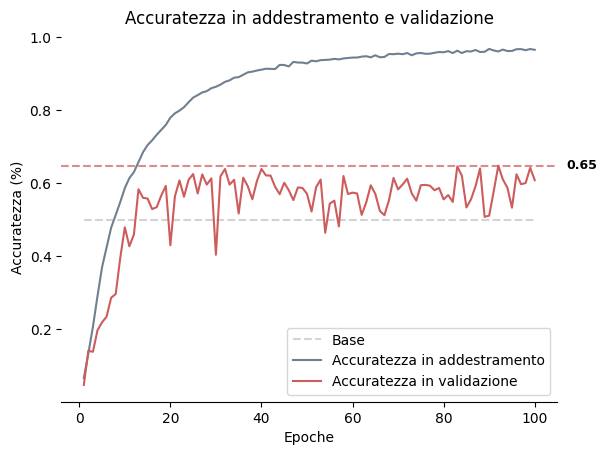

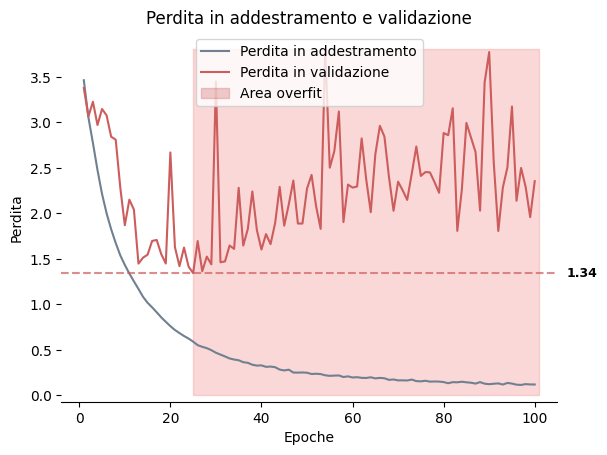

In [44]:
create_train_val_plot(bp_model_history.history)

In questo caso il modello **HA raggiunto una fase di overfitting**, inoltre le prestazioni sono diminuite di parecchio sotto qualsiasi aspetto.

In [45]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/noise/rmsprop/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(mixed_test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 7ms/step - loss: 1.4095 - accuracy: 0.6284
Accuratezza: 0.628


In [46]:
evaluate_onnx_model("bestmodels/noise/rmsprop/bp_basic_model.onnx", mixed_test_ds)

Accuratezza: 0.628


Abbiamo ottenuto un forte peggioramento per quanto riguarda l'accuratezza, ottenendo un **62.8%**.

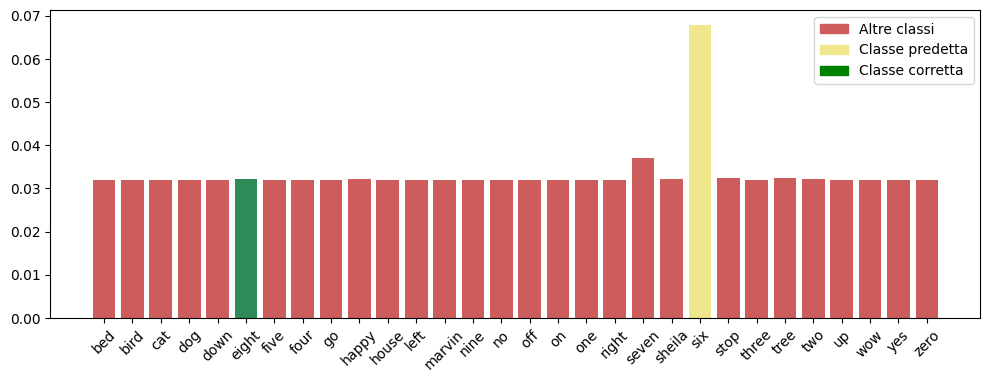

In [47]:
for audio, label in mixed_test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

La decisione del modello in questo caso è completamente sbagliata, non si è avvicinato minimamente alla classe corretta.